##### LOADING PACKAGES/LIBRARIES

In [3]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 13.6MB/s 
     |████████████████████████████████| 8.7MB 35.4MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [72]:
import pandas as pd
import numpy as np
import pmdarima as pm

In [73]:
import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt

In [74]:
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

##### LOADING DATA AND SETING THE DATA AS TIME SERIES

In [110]:
#### load data in a GSHEET  
worksheet = gc.open('Forecast_template').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df = df[1:]

In [111]:
### Converting the desired column to time series
df["DATE"] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
df["SALES_PRODX"] = pd.to_numeric(df["SALES_PRODX"])

In [112]:
## create time series
ts = df.groupby("DATE")["SALES_PRODX"].sum().rename("sales")
ts.head()

DATE
2007-03-31     970260
2007-06-30    1339077
2007-09-30    3035746
2007-12-31    3361822
2008-03-31    3360077
Name: sales, dtype: int64

In [227]:
import plotly.express as px
fig = px.line(ts, x= ts.index, y='sales')
fig.update_layout(
    plot_bgcolor='rgb(247, 247, 247)',
    autosize=False,
    width=800,
    height=400,
    title={
        'text': "Sales Time Series",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
fig.show()

### TIME SERIES ANALYSIS
1. Check for structural changes
2. Stationarity
3. Outliers
4. Seasonality

###### 1. IDENTIFYING STRUCTURAL CHANGES, IF WE NEED TO SPLIT THE MODEL  ### TO DO ENDOGENOUS / ALERT

In [114]:
### Load package needed to do the chow test to detect strcutural change
import scipy
import statsmodels.api as sm
from scipy.stats import f

In [115]:
#### separating the series per period of time
ts1 = ts.loc[:'2008-01-01']
ts2 = ts.loc['2008-01-01':]
ex1 = np.arange(ts1.shape[0])
ex2 = np.arange(ts2.shape[0])

In [116]:
#### functions to make chow test

def f_value(y1, x1, y2, x2):
    """This is the f_value function for the Chow Break test package
    Args:
        y1: Array like y-values for data preceeding the breakpoint
        x1: Array like x-values for data preceeding the breakpoint
        y2: Array like y-values for data occuring after the breakpoint
        x2: Array like x-values for data occuring after the breakpoint
    Returns:
        F-value: Float value of chow break test
    """
    def find_rss (y, x):
        """This is the subfunction to find the residual sum of squares for a given set of data
        Args:
            y: Array like y-values for data subset
            x: Array like x-values for data subset
        Returns:
            rss: Returns residual sum of squares of the linear equation represented by that data
            length: The number of n terms that the data represents
        """
        A = np.vstack([x, np.ones(len(x))]).T
        rss = np.linalg.lstsq(A, y, rcond=None)[1]
        length = len(y)
        return (rss, length)


    rss_total, n_total = find_rss(np.append(y1, y2), np.append(x1, x2))
    rss_1, n_1 = find_rss(y1, x1)
    rss_2, n_2 = find_rss(y2, x2)

    chow_nom = (rss_total - (rss_1 + rss_2)) / 2
    chow_denom = (rss_1 + rss_2) / (n_1 + n_2 - 4)
    return chow_nom / chow_denom


def p_value(y1, x1, y2, x2, **kwargs):
    F = f_value(y1, x1, y2, x2, **kwargs)
    if not F:
        return 1
    df1 = 2
    df2 = len(x1) + len(x2) - 4

    # The survival function (1-cdf) is more precise than using 1-cdf,
    # this helps when p-values are very close to zero.
    # -f.logsf would be another alternative to directly get -log(pval) instead.
    p_val = f.sf(F[0], df1, df2)
    return p_val

In [117]:
f_test = f_value(ts1, ex1, ts2, ex2)

In [118]:
p_val = p_value(ts1, ex1, ts2, ex2)

In [119]:
p_val  ####como H0 teriam os mesmos coeficientes, a rejeicao de H0 indica quebra estrutural, vamos trabalhar com o periodo pos 2008

9.259294088454889e-30

In [120]:
ts = ts2

##### Stationarity

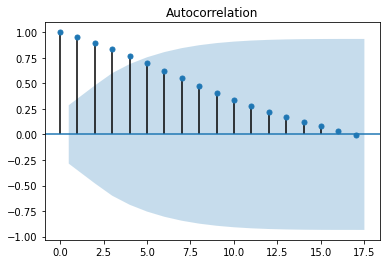

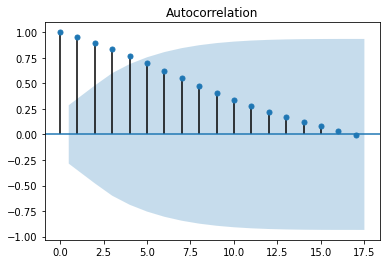

In [121]:
## distribution doesnt behave like a gaussian 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts)

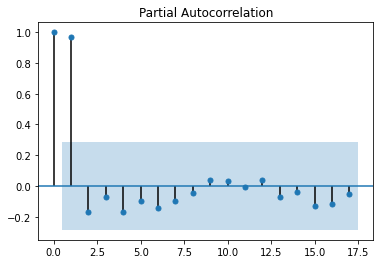

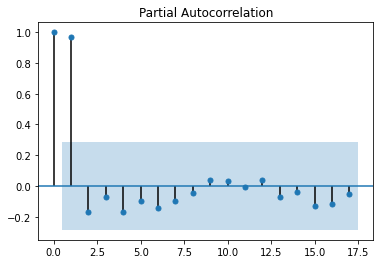

In [122]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ts)

In [123]:
### Run duckey fuller test and make the ts stationary ### colocar opcao de log
from statsmodels.tsa.stattools import adfuller
def stationarize(timeseries):
  ### run dickey fuller test and take lags until it is stationary
  ts_st = timeseries - timeseries.shift(1)
  ts_st = ts_st[1:]
  result2 = adfuller(ts_st)
  pval = result2[1]
  print('ADF Statistic: {}'.format(result2[0]))
  print('p-value: {}'.format(result2[1]))
  print('Critical Values:')
  for key, value in result2[4].items():
      print('\t{}: {}'.format(key, value)) 
  while (pval > 0.05):
    ts_st = ts_st - ts_st.shift(1)
    ts_st = ts_st[1:]
    result2 = adfuller(ts_st)
    pval = result2[1]
    print(pval)
  return ts_st


In [124]:
ts_st =  stationarize(ts)

ADF Statistic: -1.1599885381699455
p-value: 0.6905666053954718
Critical Values:
	1%: -3.6055648906249997
	5%: -2.937069375
	10%: -2.606985625
0.05720768053036005
3.478659491237308e-05


##### SPLITTING TRAIN AND TEST

In [125]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

--- splitting at index:  30 | 2016-06-30 00:00:00 | test size: 0.3  ---


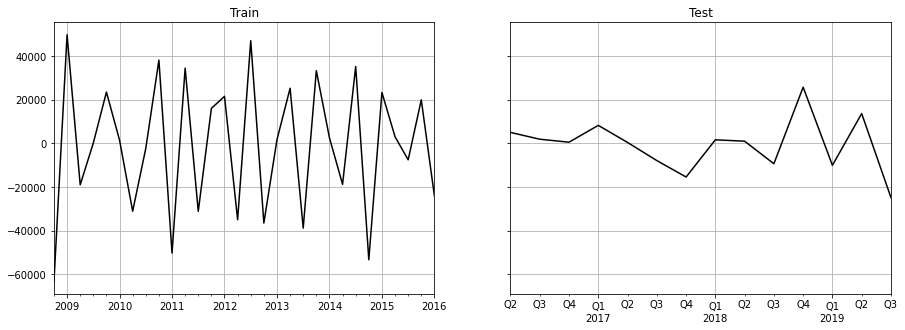

In [126]:
ts_train, ts_test = split_train_test(ts_st, test = 0.3)

##### EVALUATION METRICS

In [127]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

##### RUNNING ARIMA MODEL

In [128]:
#### finding the parametrs of the best arima model
best_model = pm.auto_arima(ts_train, seasonal=True, stationary=False, 
                                 m=7, information_criterion='aic', 
                                 max_order=20,                                     
                                 max_p=10, max_d=3, max_q=10,                                     
                                 max_P=10, max_D=3, max_Q=10,                                   
                                 error_action='ignore')
print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s): ", best_model.seasonal_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-in

best model --> (p, d, q): (4, 0, 1)  and  (P, D, Q, s):  (0, 0, 0, 7)


In [129]:
'''
Fit SARIMAX (Seasonal ARIMA with External Regressors):  
    y[t+1] = (c + a0*y[t] + a1*y[t-1] +...+ ap*y[t-p]) + (e[t] + 
              b1*e[t-1] + b2*e[t-2] +...+ bq*e[t-q]) + (B*X[t])
:parameter
    :param ts_train: pandas timeseries
    :param ts_test: pandas timeseries
    :param order: tuple - ARIMA(p,d,q) --> p: lag order (AR), d: 
                  degree of differencing (to remove trend), q: order 
                  of moving average (MA)
    :param seasonal_order: tuple - (P,D,Q,s) --> s: number of 
                  observations per seasonal (ex. 7 for weekly 
                  seasonality with daily data, 12 for yearly 
                  seasonality with monthly data)
    :param exog_train: pandas dataframe or numpy array
    :param exog_test: pandas dataframe or numpy array
:return
    dtf with predictons and the model
'''
def fit_sarimax(ts_train, ts_test, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
    ## train
    model = smt.SARIMAX(ts_train, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
    df_train = ts_train.to_frame(name="ts")
    df_train["model"] = model.fittedvalues
    
    ## test
    df_test = ts_test.to_frame(name="ts")
    df_test["forecast"] = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    
    ## evaluate
    df = df_train.append(df_test)
    title = "ARIMA "+ str(order)      
    df = utils_evaluate_forecast(df, figsize=figsize, title=title)
    return df, model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



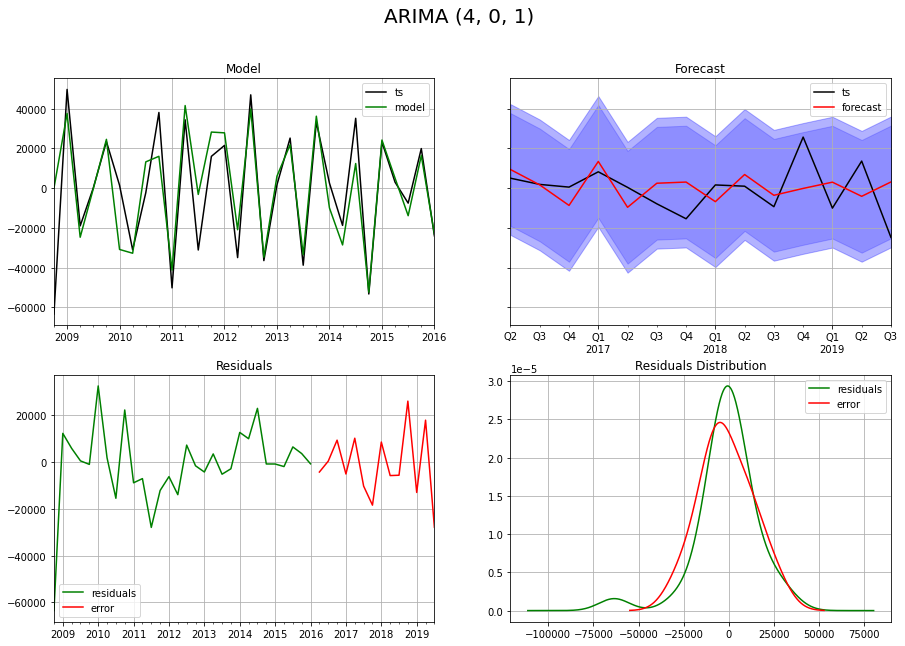

Training --> Residuals mean: -1206.0  | std: 16814.0
Test --> Error mean: -1393.0  | std: 14490.0  | mae: 11619.0  | mape: 454.0 %  | mse: 196889888.0  | rmse: 14032.0


In [130]:
df, model = fit_sarimax(ts_train, ts_test, order=best_model.order, 
                         seasonal_order=best_model.seasonal_order)

In [148]:
def forecast_sarimax(ts_total, ts, periods, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
  model = smt.SARIMAX(ts_total, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
  
  ts_predict = model.predict(start=len(ts_total), 
                            end=len(ts_total)+ periods, 
                            exog=exog_test, alpha = 0.05)
  ### making it back to (not in difference model)
  ts_pred2 = model.get_prediction(start=len(ts_total), 
                            end=len(ts_total)+ periods, 
                            exog=exog_test, alpha = 0.05)
  ts_pred_m = ts_pred2.predicted_mean
  ts_ci = ts_pred2.conf_int(alpha=0.05)
  #print(ts_ci)
  #print(ts_predict)
  last_t= ts.tail(1)
  prediction = last_t.add(ts_pred_m, fill_value=0)
  ts_predict_f = prediction.cumsum()
  ts_less = ts.drop(ts.tail(1).index)
  ts_f = ts_less.add(ts_predict_f, fill_value=0)
  ### lower
  prediction_lower = last_t.add(ts_ci["lower sales"], fill_value=0)
  ts_predict_lower = prediction_lower.cumsum()
  ts_lower = ts_less.add(ts_predict_lower, fill_value=0)
  ### upper
  prediction_upper = last_t.add(ts_ci["upper sales"], fill_value=0)
  ts_predict_upper = prediction_upper.cumsum()
  ts_upper = ts_less.add(ts_predict_upper, fill_value=0)
  ### final df
  df_forecast = pd.concat([ts, ts_f, ts_lower, ts_upper], axis=1)
  df_forecast.columns = ["series", "forecast", "forecast_lower", "forecast_upper"]
  ### make another df containning just the end
  return df_forecast


In [181]:
forecast = forecast_sarimax(ts_st, ts, periods=6, order=best_model.order, 
                         seasonal_order=best_model.seasonal_order)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



In [175]:
pd.options.display.float_format = '{:,.0f}'.format
forecast["upper_increase"] = forecast["forecast_upper"] - forecast["forecast"]
forecast["lower_decrease"] = forecast["forecast"] - forecast["forecast_lower"]


In [226]:
import plotly.express as px 
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["forecast_upper"],
    fill=None,
   # mode='lines',
    line = dict(color='rgb(199, 218, 252)', width=2, dash='dot'),
    #line_color='rgb(159, 192, 252)',
    name='Forecast Upper bound',
    ))
fig.add_trace(go.Scatter( x=forecast.index, y=forecast["forecast_lower"],
    fill='tonexty', # fill area between trace0 and trace1
    #mode='lines', 
    line = dict(color='rgb(199, 218, 252)', width=2, dash='dot'),
    name='Forecast Lower bound',
    ))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["forecast"],
                    line = dict(color='rgb(54, 90, 156)', width=2.3, dash = 'dot'),
                    name='Forecast'))
fig.add_trace(go.Scatter(x=forecast.index, y= forecast["series"],
                    line = dict(color='rgb(16, 196, 134)', width=2.9),
                    name='Series'))
fig.update_layout(
    plot_bgcolor='rgb(247, 247, 247)',
    autosize=False,
    width=1200,
    height=600,
    title={
        'text': "Sales - Forecast",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
fig.show()

###### PROPHET

In [68]:
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", 
                                                   "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", 
                                                 "sales":"y"})
dtf_train.tail()

,DATE,y
30,2014-09-30,3866199
31,2014-12-31,3894481
32,2015-03-31,3923381
33,2015-06-30,3955900
34,2015-09-30,3984485


In [69]:
model = Prophet(growth="linear", changepoints=None, 
                n_changepoints=25,
                seasonality_mode="multiplicative",
                yearly_seasonality="auto", 
                weekly_seasonality="auto", 
                daily_seasonality=False,
                holidays=None)

In [70]:
'''
Fits prophet on Business Data:
    y = trend + seasonality + holidays
:parameter
    :param dtf_train: pandas Dataframe with columns 'ds' (dates), 
             'y' (values), 'cap' (capacity if growth="logistic"), 
             other additional regressor
    :param dtf_test: pandas Dataframe with columns 'ds' (dates), 'y' 
                     (values), 'cap' (capacity if 
                      growth="logistic"), 
                      other additional regressor
    :param lst_exog: list - names of variables
    :param freq: str - "D" daily, "M" monthly, "Y" annual, "MS" 
                       monthly start ...
:return
    dtf with predictons and the model
'''
def fit_prophet(dtf_train, dtf_test, lst_exog=None, model=None, 
                freq="D", figsize=(15,10)):
    ## train
    model.fit(dtf_train)
    
    ## test
    dtf_prophet = model.make_future_dataframe(periods=len(dtf_test), 
                  freq=freq, include_history=True)
    dtf_prophet = model.predict(dtf_prophet)
    dtf_train = dtf_train.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'model', 
                'y':'ts'}).set_index("ds")
    dtf_test = dtf_test.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'forecast',  
                'y':'ts'}).set_index("ds")
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="Prophet")
    return dtf, model

In [72]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D")

ValueError: ignored